---
## Import Packages 

In [3]:
# ==========================
# Cell 1: Import Packages
# ==========================

import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygeostat as gs

# For nearest neighbor queries
from scipy import spatial

# For train/test split and performance metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score, accuracy_score, recall_score
from tensorflow import keras
from tensorflow.keras import layers

# Hyperopt for hyperparameter tuning
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import os
# Suppress warnings for clarity (optional)
warnings.filterwarnings('ignore') 

# Directories: specify your local directories here (update paths as needed)
exedir = 'exe/'
if not os.path.exists('LDM'):
    os.makedirs('LDM')

## Load Dataset and Grid Definition

125 34407.5 15.0 
80 27407.5 15.0 
40 607.5 15.0
count    3245.000000
mean      110.832859
std       148.922334
min        42.207631
25%        67.927750
50%        79.663433
75%        95.214743
max      1773.386815
Name: Data Spacing (m), dtype: float64


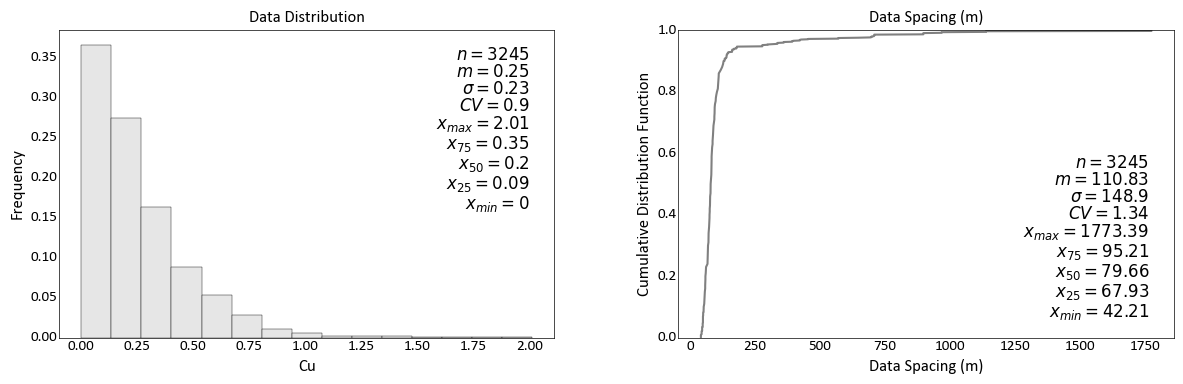

In [2]:
# ========================================
# Cell 2: Load Dataset and Grid Definition
# ========================================

# Load an example grid definition
griddef = gs.GridDef(grid_file='./Data/griddef.txt')
print(griddef)

# Load downhole/borehole (BH) data
bhdata = gs.DataFile('./Data/cudata.dat', griddef=griddef, readfl=True)

# Example: compute and inspect data spacing
bhdata.spacing(100)
print(bhdata['Data Spacing (m)'].describe())

# Quick histograms of the data
fig1, axes = plt.subplots(1, 2, figsize=(12, 4))

gs.histogram_plot(bhdata, var='Cu', title='Data Distribution', ax=axes[0])
gs.histogram_plot(bhdata, var='Data Spacing (m)', icdf=True,
                  title='Data Spacing (m)', ax=axes[1])
fig1.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()


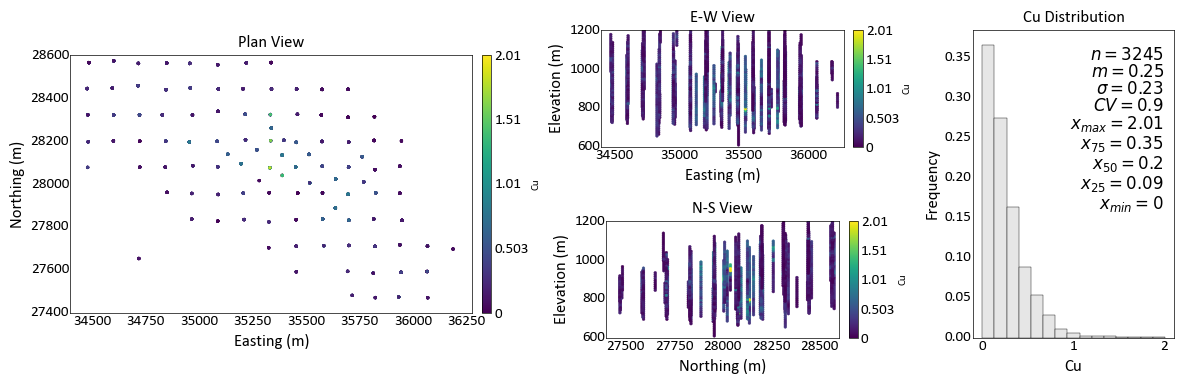

In [3]:
# =================================================
# Cell 3: Visualizing Borehole Locations in 2D/3D
# =================================================

import matplotlib.pyplot as plt
from matplotlib import gridspec

fig1 = plt.figure(figsize=(12, 4))
gs2 = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[2, 2, 1])

# Define subplots
ax0 = fig1.add_subplot(gs2[:, 0])  # Plan view
ax1 = fig1.add_subplot(gs2[0, 1])  # E-W view
ax2 = fig1.add_subplot(gs2[1, 1])  # N-S view
ax3 = fig1.add_subplot(gs2[:, 2])  # Histogram

# Plot plan, E-W, and N-S views + distribution histogram
gs.location_plot(bhdata, var='Cu', title='Plan View', cbar_label='Cu',
                 griddef=griddef, s=4, orient='xy', ax=ax0, aspect=1)
gs.location_plot(bhdata, var='Cu', title='E-W View', cbar_label='Cu',
                 griddef=griddef, s=4, orient='xz', ax=ax1, aspect=1.5)
gs.location_plot(bhdata, var='Cu', title='N-S View', cbar_label='Cu',
                 griddef=griddef, s=4, orient='yz', ax=ax2, aspect=1)
gs.histogram_plot(bhdata, var='Cu', title='Cu Distribution', ax=ax3)

plt.tight_layout()
plt.show()


In [4]:
# ============================================
# Cell 4: Generate Prediction Grid Coordinates
# ============================================

#  Get the grid coordinates (x, y, z)
x, y, z = griddef.get_coordinates()
grid_coords = np.hstack((
    x.reshape(len(x), 1),
    y.reshape(len(y), 1),
    z.reshape(len(z), 1)
))


## Kfold

./Data/kfold.out


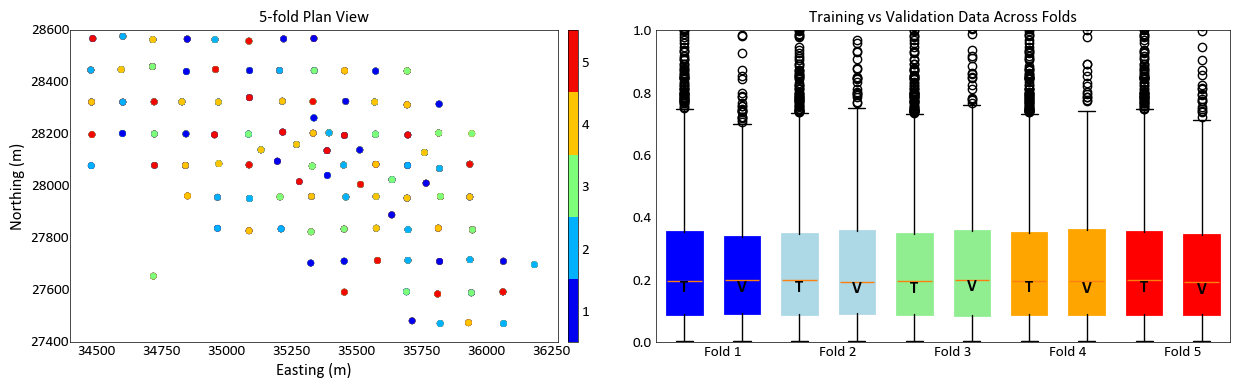

In [5]:
# ============================
# Cell 5: K-Fold (if available)
# ============================

# Parameter string for kfold (Program usage depends on local exe)

foldpar = """                  Parameters for KFOLD
                  ********************

START OF PARAMETERS:
{datafl}                     - file with data
0 1 2 3 4                    - columns for DH,X,Y,Z,VR
-1.0     1.0e21              - trimming limits
{outfl}                      - file for output
1                            - write Validation and Training files?
5                            - number of folds
1324978                      - random number seed
0.001  0.01  0.25   0.50     - weights: random, centroid, diff, same
"""
# If you have a compiled kfold executable, you can run:
# kfold = gs.Program(program = exedir + 'kfold')
# kfold.run(
#     parstr=foldpar.format(
#         outfl='./Data/kfold.out',
#         datafl=bhdata.flname
#     ),
#     liveoutput=False
# )

# After running, we'd load the folds:
kfold = gs.DataFile(
    './Data/kfold.out',
    cat='Fold (out of   5)',
    catdict={1:1, 2:2, 3:3, 4:4, 5:5}
)
print(kfold)

# Visual example: loading training & validation data for each fold
import matplotlib.pyplot as plt
from matplotlib import gridspec

training_data = []
validation_data = []

for fold in range(1, 6):
    # Replace './Data/Training0{}.dat' with the actual filenames output from kfold
    Training = gs.DataFile(f'./Data/Training0{fold}.dat', x='X', y='Y', z='Z')
    Validation = gs.DataFile(f'./Data/Validation0{fold}.dat', x='X', y='Y', z='Z')
    
    training_values = Training['Cu']
    validation_values = Validation['Cu']
    
    training_data.append(training_values)
    validation_data.append(validation_values)

# Boxplot demonstration
labels = []
for fold in range(1, 6):
    labels.append(f'Training Fold {fold}')
    labels.append(f'Validation Fold {fold}')

fig1 = plt.figure(figsize=(13, 4))
gs2 = gridspec.GridSpec(1, 2)

ax0 = fig1.add_subplot(gs2[:, 0])
ax3 = fig1.add_subplot(gs2[:, 1])

kfold = gs.DataFile('./Data/kfold.out', cat='Fold (out of   5)', catdict={1:1, 2:2, 3:3, 4:4, 5:5})

# 2D location plot colored by fold number
gs.location_plot(kfold, var='Fold (out of   5)', cmap='jet', griddef=griddef, 
                 title='5-fold Plan View', s=20, orient='xy', ax=ax0)

colors = ['blue', 'lightblue', 'lightgreen', 'orange', 'red']  

for i in range(5):
    bp = ax3.boxplot(
        [training_data[i], validation_data[i]],
        positions=[i*2+1, i*2+2],
        widths=0.6, patch_artist=True
    )
    for j, box in enumerate(bp['boxes']):
        box.set(color=colors[i], linewidth=2)
        box.set(facecolor=colors[i])
        median = bp['medians'][j]
        median_y = median.get_ydata()[0]
        ax3.text(
            i*2 + 1 + j, median_y - 0.05*(median_y - median.get_ydata()[1]),
            'T' if j == 0 else 'V',
            ha='center', va='top', fontweight='bold'
        )

ax3.set_title('Training vs Validation Data Across Folds', fontsize=12)
ax3.set_xticks([i*2+2 for i in range(5)])
ax3.set_xticklabels([f'Fold {i+1}' for i in range(5)], ha='right')
ax3.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## DeepKriging

In [ ]:
# ============================
# Cell 6: Deep Kriging (Setup)
# ============================

import numpy as np
import pandas as pd
from scipy import spatial

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model Selection / Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Hyperopt
from hyperopt import fmin, tpe, hp, Trials

# 1) Normalize entire domain grid
df1 = pd.DataFrame(grid_coords, columns=['X', 'Y', 'Z'])
lon = df1['X'].values
lat = df1['Y'].values
elev = df1['Z'].values

normalized_lon = (lon - lon.min()) / (lon.max() - lon.min())
normalized_lat = (lat - lat.min()) / (lat.max() - lat.min())
normalized_elev = (elev - elev.min()) / (elev.max() - elev.min())

s_test = np.vstack((normalized_lon, normalized_lat, normalized_elev)).T

# 2) Build Wendland basis
def wendland_basis_w3_s3(lon_norm, lat_norm, elev_norm):
    """
    Creates the Wendland kernel basis (phi) for the entire domain.
    Returns phi with zero columns removed.
    """
    N = len(lon_norm)
    # Example: using 5^3 = 125 knots
    num_basis = 5**3
    knots_1dx = np.linspace(0, 1, int(np.cbrt(num_basis)))
    knots_1dy = np.linspace(0, 1, int(np.cbrt(num_basis)))
    knots_1dz = np.linspace(0, 1, int(np.cbrt(num_basis)))

    theta = 1 / np.cbrt(num_basis) * 2.5
    knots_x, knots_y, knots_z = np.meshgrid(knots_1dx, knots_1dy, knots_1dz)
    knots = np.column_stack((knots_x.flatten(), knots_y.flatten(), knots_z.flatten()))
    
    phi = np.zeros((N, num_basis), dtype=float)
    
    for k_i in range(num_basis):
        current_knot = knots[k_i, :]
        distances = np.linalg.norm(
            np.vstack((lon_norm, lat_norm, elev_norm)).T - current_knot,
            axis=1
        ) / theta

        # Wendland w3,s3
        mask = (distances >= 0) & (distances <= 1)
        phi[mask, k_i] = (
            (1 - distances[mask])**6 *
            (35*distances[mask]**2 + 18*distances[mask] + 3) / 3
        )
        
    # Remove columns that might be all zeros
    col_sums = np.sum(phi != 0, axis=0)
    nonzero_cols = np.where(col_sums > 0)[0]
    phi_reduce = phi[:, nonzero_cols]

    return phi_reduce

phi_reduce_full = wendland_basis_w3_s3(normalized_lon, normalized_lat, normalized_elev)


In [ ]:
# ===========================
# Cell 7: Deep Kriging (Main)
# ===========================

# Outer 5-fold loop
for fold in range(1, 6):
    print(f"\n========== OUTER FOLD {fold} ==========")

    # Load outer-train data
    Traindat = gs.DataFile(f'./Data/Training0{fold}.dat', x='X', y='Y', z='Z')
    df_train = Traindat.data

    # KD-Tree to link training stations to grid
    df1_coords = df1[['X', 'Y', 'Z']].values  # entire domain
    tree = spatial.KDTree(df1_coords)
    idx = tree.query(df_train[['X', 'Y', 'Z']].values)[1]

    # Average value of Cu for each neighbor index
    df_train_neighbor = df_train.assign(neighbor=idx)
    df_pm25 = df_train_neighbor.groupby('neighbor')['Cu'].mean()

    # Row indices in the domain grid
    idx_new = df_pm25.index.values
    pm25 = df_pm25.values

    # Observed domain subset: normalized coords + Wendland basis
    s_obs = np.vstack((
        normalized_lon[idx_new],
        normalized_lat[idx_new],
        normalized_elev[idx_new]
    )).T
    phi_obs = phi_reduce_full[idx_new, :]

    X_full = np.hstack((s_obs, phi_obs))
    y_full = pm25.reshape(-1, 1)

    # Define model builder
    def create_model(hparams, input_dim):
        """
        Build Keras model using hyperparameters.
        """
        l1_fixed = 1e-6
        l2_fixed = 1e-4
        neurons = int(hparams['neurons'])

        model = Sequential()

        # Hidden layer 1
        model.add(Dense(
            neurons,
            input_dim=input_dim,
            kernel_initializer='he_uniform',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_fixed, l2=l2_fixed)
        ))
        model.add(Dropout(hparams['dropout']))

        # Hidden layer 2
        model.add(Dense(
            neurons,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_fixed, l2=l2_fixed)
        ))
        model.add(Dropout(hparams['dropout']))

        # Hidden layer 3
        model.add(Dense(
            neurons,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_fixed, l2=l2_fixed)
        ))
        model.add(Dropout(hparams['dropout']))

        # Output layer
        model.add(Dense(1, activation='linear'))

        optimizer = Adam(learning_rate=hparams['learning_rate'])
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    # Inner 5-fold CV for hyperparameter tuning
    def hyperopt_objective(hparams):
        epochs = int(hparams['epochs'])
        batch_size = int(hparams['batch_size'])

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        fold_mses = []

        for train_idx, val_idx in kf.split(X_full):
            X_tr, X_val = X_full[train_idx], X_full[val_idx]
            y_tr, y_val = y_full[train_idx], y_full[val_idx]

            model = create_model(hparams, input_dim=X_full.shape[1])
            model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)
            
            y_val_pred = model.predict(X_val)
            fold_mses.append(mean_squared_error(y_val, y_val_pred))
        
        return np.mean(fold_mses)  # minimize MSE

    search_space = {
        'neurons':       hp.quniform('neurons', 400, 800, 200),
        'dropout':       hp.uniform('dropout', 0.2, 0.5),
        'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
        'epochs':        hp.quniform('epochs', 200, 400, 100),
        'batch_size':    hp.quniform('batch_size', 16, 64, 16),
    }

    trials = Trials()
    best = fmin(
        fn=hyperopt_objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=5,  ### Please increase here if you want to find better results. 
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    best['neurons']    = int(best['neurons'])
    best['epochs']     = int(best['epochs'])
    best['batch_size'] = int(best['batch_size'])
    print("Best hyperparameters from inner CV:", best)

    # Retrain final model with full outer-train data
    final_model = create_model(best, input_dim=X_full.shape[1])
    final_model.fit(X_full, y_full, epochs=best['epochs'], batch_size=best['batch_size'], verbose=0)

    # Predict on entire domain
    X_RBF_pred = np.hstack((s_test, phi_reduce_full))
    PM25_pred = final_model.predict(X_RBF_pred)
    PM25_pred[PM25_pred < 0] = 0  # optional clipping

    outfile = f'DeepKriging_{fold}.out'
    gs.write_gslib(pd.DataFrame(PM25_pred), outfile)
    print(f"Domain predictions saved: {outfile}")

    # Evaluate on external/validation set
    testfile = gs.DataFile(flname=f'./Data/Validation0{fold}.dat', griddef=griddef, readfl=True)
    DeepKriging = gs.DataFile(f'DeepKriging_{fold}.out', griddef=griddef)

    idx, ingrid = griddef.get_index(
        x=testfile.data['X'],
        y=testfile.data['Y'],
        z=testfile.data['Z']
    )
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx >= 0]

    r2_value = r2_score(testfile['Cu'], DeepKriging.data['0'][idx].values)


## Ordinary Kriging

In [ ]:
# ===================================
# Cell 8: Ordinary Kriging Parameters
# ===================================

# Example parameters for KT3DN (if you have the compiled program):
kt3dnpar = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}                         -file with data
0  {xyzcol} {varcol}  0          -columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -number to search and composite length
0    100   0                     -debugging level: ...
kt3dn.dbg-nkt3dn.sum             -file for debugging output
{outfl}                          -file for kriged output
{griddef}
5    5      5                    -x,y,z block discretization
4    48    12    1               -min,max data for kriging, ...
90      0                        -max per octant, ...
500.0  500.0  500.0              -maximum search radii
110.0   0   0.0                  -angles for search ellipsoid
1                                -0=SK,1=OK,...
0.180 0.6  0.8                   -mean, ...
0 0 0 0 0 0 0 0 0                -drift parameters
0                                -0, variable
extdrift.out                     -gridded file with drift/mean
4                                -column number in gridded file
key_out.out                      -gridded file with keyout
0    1                           -column (0 if no keyout) and value to keep
2    0.001                       -nugget effect
1    0.34   110.0   -10.0   0.0  - it,cc,ang1,ang2,ang3
       55    55    30            - a_hmax, a_hmin, a_vert
1    0.659   110.0   -10.0   0.0  - it,cc,ang1,ang2,ang3
       300    300    300         - a_hmax, a_hmin, a_vert
"""

# If you have kt3dn, you can run something like this:
kt3dn = gs.Program(program=exedir + '/kt3dn')
for fold in range(1, 6):
    Traindat = gs.DataFile(
        flname=f'./Data/Training0{fold}.dat',
        griddef=griddef,
        readfl=True
    )
    kt3dn.run(parstr=kt3dnpar.format(
        datafl=Traindat.flname,
        xyzcol=Traindat.gscol(Traindat.xyz),
        varcol=Traindat.gscol('Cu'),
        griddef=griddef,
        outfl=f'OK_{fold}.out'
    ))


## DeepKriging + LDM (Local Means, Variances)

In [ ]:
# ==================================================
# Cell 9: DeepKriging + LDM (Local Means, Variances)
# ==================================================

import itertools

parstr = """                  Parameters for LDWgenerator
                  **********************

START OF PARAMETERS:
{datafl}                 - file with data
1  2  3  4  0            - columns for X, Y, Z coordinates variable and weight
-1.0     1.0e21          - trimming limits
1                        - including declustering weights by? 0 = scaling, 1=self calibration
1                        - Parameter calibration mode? no = 0, yes =1
1                        - anchor points in file =0, in grid =1
{grid}
aploc.clp                - file with anchor points locations
1  2  3                  - columns for X, Y, Z anchor point coordinates
1  4  3                  - weighting function (1=ID, 2=GK) and parameters
0                        - dynamic bandwidth? 0=no, 1=yes
 110.0  0.0  0.0         - anisotropic search angles
 500.0  500.0  500.0     - anisotropic search radius
{weightsfl}              - file for weights output
{debuggingfl}            - file for debugging
{sumfl}                  - file for summary
"""

# If you have LDWgenerator program:
LDWgenerator = gs.Program(program='./exe/LDWgenerator', getpar=True)
for fold in range(1, 6):
    Traindat = gs.DataFile(
        flname=f'./Data/Training0{fold}.dat',
        griddef=griddef,
        readfl=True
    )
    LDWgenerator.run(parstr=parstr.format(
        datafl=Traindat.flname,
        grid=griddef,
        weightsfl=f'./LDM/Weights_{fold}.out',
        debuggingfl=f'./LDM/Debug_{fold}.out',
        sumfl=f'./LDM/Sum_{fold}.out'
    ), liveoutput=False)


## Combination (DeepKriging + LDM)

In [6]:
# ========================================
# Cell 10: Combination (DeepKriging + LDM)
# ========================================

for fold in range(1, 6):
    deepkriging = gs.DataFile(f'DeepKriging_{fold}.out', griddef=griddef)
    moment = gs.DataFile(f'./LDM/Debug_{fold}.out', x='APX', y='APY')
    
    moment.data['Variance'] = moment.data['Local std.dev.']**2
    moment.data['Scaled_Variance'] = (
        moment.data['Variance'] - moment.data['Variance'].min()
    ) / (moment.data['Variance'].max() - moment.data['Variance'].min())


    weight = moment['Scaled_Variance'] ** 0.25
    cond_DK = deepkriging['0'] * np.array(weight) + moment['Local Mean'] * (1 - np.array(weight))

    gs.write_gslib(
        pd.DataFrame(cond_DK),
        f'./LDM/Weighted_DK_{fold}.out'
    )


## Comparison of All Methods

In [7]:
# =================================
# Cell 11: Comparison of All Methods
# =================================

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd

OK_R2 = 0
DeepKriging_R2 = 0
Cond_DK_R2 = 0

OK_Ensemble = 0
DeepKriging_Ensemble = 0
Cond_DK_Ensemble = 0

for fold in range(1, 6):
    testfile = gs.DataFile(flname=f'./Data/Validation0{fold}.dat', griddef=griddef, readfl=True)
    
    # OK
    OK = gs.DataFile(f'OK_{fold}.out', griddef=griddef)
    # Clip negative
    OK.data.loc[OK.data['Estimate'] < 0, 'Estimate'] = 0

    # DeepKriging
    DeepKriging = gs.DataFile(f'DeepKriging_{fold}.out', griddef=griddef)

    # Cond_DK
    Cond_DK = gs.DataFile(f'./LDM/Weighted_DK_{fold}.out', griddef=griddef)

    idx, ingrid = griddef.get_index(
        x=testfile.data['X'],
        y=testfile.data['Y'],
        z=testfile.data['Z']
    )
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx >= 0]


    # Accumulate R2
    OK_R2 += r2_score(testfile['Cu'], OK.data['Estimate'][idx].values)
    DeepKriging_R2 += r2_score(testfile['Cu'], DeepKriging.data['0'][idx].values)
    Cond_DK_R2 += r2_score(testfile['Cu'], Cond_DK.data['0'][idx].values)

    # Ensemble predictions
    OK_Ensemble += OK.data['Estimate'].values.reshape(-1, 1)
    DeepKriging_Ensemble += DeepKriging.data['0'].values.reshape(-1, 1)
    Cond_DK_Ensemble += Cond_DK.data['0'].values.reshape(-1, 1)

OK_Performance = round(OK_R2 / 5, 3)
DeepKriging_Performance = round(DeepKriging_R2 / 5, 1)
Cond_DK_Performance = round(Cond_DK_R2 / 5, 2)

# Compute average ensemble predictions
OK_Avg = OK_Ensemble / 5
DeepKriging_Avg = DeepKriging_Ensemble / 5
Cond_DK_Avg = Cond_DK_Ensemble / 5

gs.write_gslib(pd.DataFrame(OK_Avg), 'OK_Average.out')
gs.write_gslib(pd.DataFrame(DeepKriging_Avg), 'DeepKriging_Average.out')
gs.write_gslib(pd.DataFrame(Cond_DK_Avg), 'Cond_DK_Average.out')

print("DeepKriging_Avg describe:")
print(pd.DataFrame(DeepKriging_Avg).describe())

print("Avg R2 scores => OK:", OK_Performance, 
      "DeepKriging:", DeepKriging_Performance, 
      "Cond_DK:", Cond_DK_Performance)


DeepKriging_Avg describe:
                   0
count  400000.000000
mean        0.147622
std         0.126245
min         0.020144
25%         0.077965
50%         0.100366
75%         0.166522
max         1.392768
Avg R2 scores => OK: 0.668 DeepKriging: 0.6 Cond_DK: 0.66


In [8]:
# =======================
# Cell 12: Compute RMSE
# =======================

from sklearn.metrics import mean_squared_error

OK_RMSE = 0
DeepKriging_RMSE = 0
Cond_DK_RMSE = 0

for fold in range(1, 6):
    testfile = gs.DataFile(flname=f'./Data/Validation0{fold}.dat', griddef=griddef, readfl=True)
    
    OK = gs.DataFile(f'OK_{fold}.out', griddef=griddef)
    OK.data.loc[OK.data['Estimate'] < 0, 'Estimate'] = 0
    
    DeepKriging = gs.DataFile(f'DeepKriging_{fold}.out', griddef=griddef)
    Cond_DK = gs.DataFile(f'./LDM/Weighted_DK_{fold}.out', griddef=griddef)
    
    idx, ingrid = griddef.get_index(
        x=testfile.data['X'],
        y=testfile.data['Y'],
        z=testfile.data['Z']
    )
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx >= 0]
    
    OK_rmse = np.sqrt(mean_squared_error(testfile['Cu'], OK.data['Estimate'][idx].values))
    DeepKriging_rmse = np.sqrt(mean_squared_error(testfile['Cu'], DeepKriging.data['0'][idx].values))
    Cond_DK_rmse = np.sqrt(mean_squared_error(testfile['Cu'], Cond_DK.data['0'][idx].values))

    OK_RMSE += OK_rmse
    DeepKriging_RMSE += DeepKriging_rmse
    Cond_DK_RMSE += Cond_DK_rmse

OK_Performance = round(OK_RMSE / 5, 3)
DeepKriging_Performance = round(DeepKriging_RMSE / 5, 3)
Cond_DK_Performance = round(Cond_DK_RMSE / 5, 3)

print("Avg RMSE => OK:", OK_Performance, 
      "DeepKriging:", DeepKriging_Performance,
      "Cond_DK:", Cond_DK_Performance)


Avg RMSE => OK: 0.135 DeepKriging: 0.15 Cond_DK: 0.136


## Some Final Visual Plots

In [9]:
ok_results = gs.DataFile('OK_Average.out')
deepkriging_results = gs.DataFile('DeepKriging_Average.out')
Cond_DK_results = gs.DataFile('Cond_DK_Average.out')

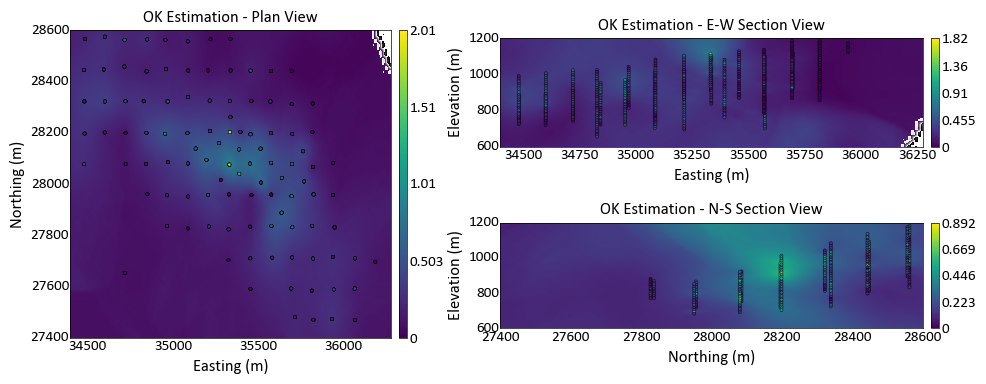

In [10]:
# ================================
# Cell 14: Slice Plots (OK Result)
# ================================
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig1 = plt.figure(figsize=(10, 4))
gs2 = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax0 = fig1.add_subplot(gs2[:, 0])
ax1 = fig1.add_subplot(gs2[0, 1])
ax2 = fig1.add_subplot(gs2[1, 1])

gs.slice_plot(
    ok_results, var='0', 
    pointdata=bhdata, pointvar='Cu', griddef=griddef, 
    pointkws={'edgecolors': 'k', 's':5},
    title='OK Estimation - Plan View', ax=ax0,
    slice_number=20, aspect=1.5, slice_thickness=10
)

gs.slice_plot(
    ok_results, var='0',
    pointdata=bhdata, pointvar='Cu', griddef=griddef,
    pointkws={'edgecolors': 'k', 's':5},
    title='OK Estimation - E-W Section View', ax=ax1,
    slice_number=60, aspect=0.8, orient='xz', slice_thickness=10
)

gs.slice_plot(
    ok_results, var='0',
    pointdata=bhdata, pointvar='Cu', griddef=griddef,
    pointkws={'edgecolors': 'k', 's':5},
    title='OK Estimation - N-S Section View', ax=ax2,
    slice_number=40, aspect=0.5, orient='yz', slice_thickness=10
)

plt.tight_layout(h_pad=3, w_pad=1.5)
# plt.savefig("Figure13a.png", dpi=300, bbox_inches='tight')
plt.show()


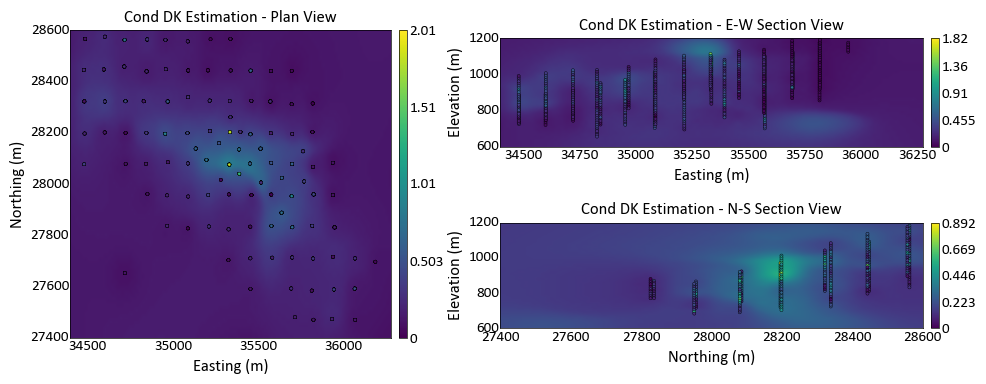

In [11]:
# =====================================
# Cell 15: Slice Plots (Cond_DK Result)
# =====================================

fig1 = plt.figure(figsize=(10, 4))
gs2 = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax0 = fig1.add_subplot(gs2[:, 0])
ax1 = fig1.add_subplot(gs2[0, 1])
ax2 = fig1.add_subplot(gs2[1, 1])

gs.slice_plot(
    Cond_DK_results, var='0',
    pointdata=bhdata, pointvar='Cu', griddef=griddef,
    pointkws={'edgecolors': 'k', 's':5},
    title='Cond DK Estimation - Plan View', ax=ax0,
    slice_number=20, aspect=1.5, slice_thickness=10
)

gs.slice_plot(
    Cond_DK_results, var='0',
    pointdata=bhdata, pointvar='Cu', griddef=griddef,
    pointkws={'edgecolors': 'k', 's':5},
    title='Cond DK Estimation - E-W Section View', ax=ax1,
    slice_number=60, aspect=0.8, orient='xz', slice_thickness=10
)

gs.slice_plot(
    Cond_DK_results, var='0',
    pointdata=bhdata, pointvar='Cu', griddef=griddef,
    pointkws={'edgecolors': 'k', 's':5},
    title='Cond DK Estimation - N-S Section View', ax=ax2,
    slice_number=40, aspect=0.5, orient='yz', slice_thickness=10
)

plt.tight_layout(h_pad=3, w_pad=1.5)
# plt.savefig("Figure13b.png", dpi=300, bbox_inches='tight')
plt.show()
